In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

from net_flow_opt.utils import components, structure
from net_flow_opt.network import Activity, System
from net_flow_opt.model import ThreeObjective
from net_flow_opt.callbacks import TrackPerformance


Main parameters of the experiment are declared here.

In [2]:
pop_size = 400
termination = ('n_gen', 600)
seed = 2384987
eps = 1e-3

The cells below repeat the experiment with a different number of resources.

In [3]:
def experiment():
    system = System(structure, components)

    activities = [Activity(component) for component in system.components]

    problem = ThreeObjective(system=system)

    # calculate a reference point for the calculation of HV
    T = 200
    dates = np.array([a.t for a in activities])
    d_t = np.vstack([- dates, T - dates])
    i = np.argmax(np.abs(d_t), axis=0)
    d_t = d_t[i, np.arange(d_t.shape[1])]

    ref_point = np.array([
        system.regular_flow * T,
        np.sum([a.h(d_t[i] + eps) for i, a in enumerate(activities)])
    ])

    algorithm = NSGA2(
        pop_size=pop_size,
        eliminate_duplicates=True,
        callback=TrackPerformance(ref_point=ref_point)
    )

    res = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=termination,
        seed=seed,
    )

    return res

In [4]:
alg_name = 'three-obj'

res = experiment()

# save data
df = pd.DataFrame(res.opt.get("F"), columns=['IC', 'LF', 'RE'])
df.to_csv(f'../data/{alg_name}.csv', index=False)

df = pd.DataFrame(np.array(res.algorithm.callback.data['hv']), columns=['HV'])
df.index.name = 'iter'
df.to_csv(f'../data/{alg_name}.csv')

with open(f'../data/{alg_name}', 'wb') as f:
    dill.dump(res, f)

print(f"Experiment completed.")

Experiment completed.


Run the experiment using the number of iterations to stop the algorithm.

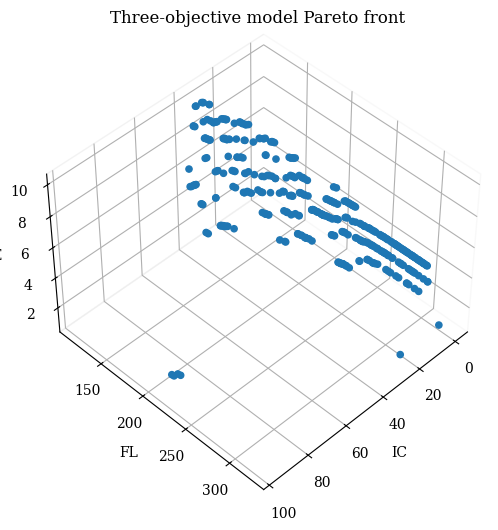

In [5]:
with open('../data/three-obj', 'rb') as f:
    res = dill.load(f)

F = res.opt.get("F")
plot = Scatter(
    title="Three-objective model Pareto front",
    labels=['IC', 'FL', 'RE']
)
plot.add(F)
plot.show()

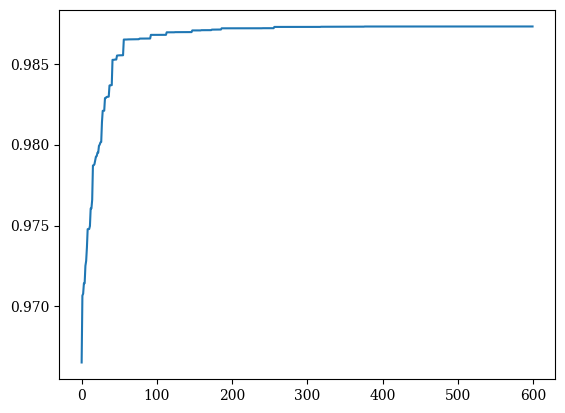

In [6]:
hv = np.array(res.algorithm.callback.data['hv'])

plt.plot(hv)